# AI 201 Mini Project
## Coffee Match: Leveraging Machine Learning for Coffee Bean Recommendations Using Taste Profiles
### Exploratory Data Analysis on the Coffee Quality Institute 2018 Dataset

Submitted by: 
Jan Lendl R. Uy, 2019-00312

### Download the necessary packages

In [1]:
%pip install pandas seaborn matplotlib numpy imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import traceback
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

### Load the dataset as a dataframe

In [3]:
df = pd.read_csv("datasets/merged_data_cleaned.csv")

In [4]:
df.head()

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,0,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,2,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
3,3,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,...,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
4,4,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


### Format column names in snake-case

In [5]:
# Function to convert to snake case
def to_snake_case(name):
    # Replace dots and spaces with underscore
    name = name.replace('.', '_').replace(' ', '_')
    # Remove any double underscores
    name = name.replace('__', '_')
    # Convert to lowercase
    return name.lower()

In [6]:
# Get current columns and create a mapping dictionary
column_mapping = {col: to_snake_case(col) for col in df.columns}

# Rename the columns
df = df.rename(columns=column_mapping)

In [7]:
print(df.columns)

Index(['unnamed:_0', 'species', 'owner', 'country_of_origin', 'farm_name',
       'lot_number', 'mill', 'ico_number', 'company', 'altitude', 'region',
       'producer', 'number_of_bags', 'bag_weight', 'in_country_partner',
       'harvest_year', 'grading_date', 'owner_1', 'variety',
       'processing_method', 'aroma', 'flavor', 'aftertaste', 'acidity', 'body',
       'balance', 'uniformity', 'clean_cup', 'sweetness', 'cupper_points',
       'total_cup_points', 'moisture', 'category_one_defects', 'quakers',
       'color', 'category_two_defects', 'expiration', 'certification_body',
       'certification_address', 'certification_contact', 'unit_of_measurement',
       'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters'],
      dtype='object')


### Remove preliminary set of columns not relevant to coffee profiles

In [8]:
columns_to_drop = [
    "owner",
    "owner_1",
    "grading_date",
    "unnamed:_0",  # unnamed index column
    "certification_address", 
    "certification_contact",
    "ico_number",
    "lot_number",
    "expiration",
    "altitude", # No need since this is a range
    "altitude_low_meters", # No need since average is already specified in altitude_mean_meters
    "altitude_high_meters", # No need since average is already specified in altitude_mean_meters
    "in_country_partner",
    "unit_of_measurement"
]

cleaned_df = df.drop(columns_to_drop, axis=1)

In [9]:
print(cleaned_df.columns)

Index(['species', 'country_of_origin', 'farm_name', 'mill', 'company',
       'region', 'producer', 'number_of_bags', 'bag_weight', 'harvest_year',
       'variety', 'processing_method', 'aroma', 'flavor', 'aftertaste',
       'acidity', 'body', 'balance', 'uniformity', 'clean_cup', 'sweetness',
       'cupper_points', 'total_cup_points', 'moisture', 'category_one_defects',
       'quakers', 'color', 'category_two_defects', 'certification_body',
       'altitude_mean_meters'],
      dtype='object')


### Remove mean altitudes that are $>8848 m$
This is not possible. Highest elevation above sea level is the peak of Mount Everest, which is at 8,848 meters.

In [10]:
# Print statistics before cleaning
print("Before cleaning:")
print("Number of values above 8,848m:", len(cleaned_df[cleaned_df['altitude_mean_meters'] > 8848]))
print("Maximum altitude:", cleaned_df['altitude_mean_meters'].max())
print("Total non-null values:", cleaned_df['altitude_mean_meters'].count())

# Replace values above 8,848m with NaN
cleaned_df['altitude_mean_meters'] = cleaned_df['altitude_mean_meters'].apply(
    lambda x: np.nan if pd.notnull(x) and x > 8848 else x
)

# Print statistics after cleaning
print("\nAfter cleaning:")
print("Number of values above 8,848m:", len(cleaned_df[cleaned_df['altitude_mean_meters'] > 8848]))
print("Maximum altitude:", cleaned_df['altitude_mean_meters'].max())
print("Total non-null values:", cleaned_df['altitude_mean_meters'].count())

# Show some examples of rows where values were changed
print("\nRows where altitude was set to NaN (showing original altitude_mean_meters):")
mask = cleaned_df['altitude_mean_meters'] > 8848
if len(cleaned_df[mask]) > 0:
    print(cleaned_df[mask][['country_of_origin', 'altitude_mean_meters', 'altitude_mean_meters', 'unit_of_measurement']])
else:
    print("No values were found above 8,848m")

# Basic statistics of the cleaned altitude column
print("\nStatistics of cleaned standardized altitude:")
print(cleaned_df['altitude_mean_meters'].describe())

Before cleaning:
Number of values above 8,848m: 4
Maximum altitude: 190164.0
Total non-null values: 1109

After cleaning:
Number of values above 8,848m: 0
Maximum altitude: 4287.0
Total non-null values: 1105

Rows where altitude was set to NaN (showing original altitude_mean_meters):
No values were found above 8,848m

Statistics of cleaned standardized altitude:
count    1105.000000
mean     1327.765497
std       486.357350
min         1.000000
25%      1100.000000
50%      1310.640000
75%      1600.000000
max      4287.000000
Name: altitude_mean_meters, dtype: float64


## Initial exploratory data analysis

In [11]:
# Basic information about the dataset
print(cleaned_df.info())  # Data types and null values
print(cleaned_df.describe())  # Statistical summary of numerical columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   species               1339 non-null   object 
 1   country_of_origin     1338 non-null   object 
 2   farm_name             980 non-null    object 
 3   mill                  1021 non-null   object 
 4   company               1130 non-null   object 
 5   region                1280 non-null   object 
 6   producer              1107 non-null   object 
 7   number_of_bags        1339 non-null   int64  
 8   bag_weight            1339 non-null   object 
 9   harvest_year          1292 non-null   object 
 10  variety               1113 non-null   object 
 11  processing_method     1169 non-null   object 
 12  aroma                 1339 non-null   float64
 13  flavor                1339 non-null   float64
 14  aftertaste            1339 non-null   float64
 15  acidity              

In [12]:
# Check for missing values
print(cleaned_df.isnull().sum())

species                   0
country_of_origin         1
farm_name               359
mill                    318
company                 209
region                   59
producer                232
number_of_bags            0
bag_weight                0
harvest_year             47
variety                 226
processing_method       170
aroma                     0
flavor                    0
aftertaste                0
acidity                   0
body                      0
balance                   0
uniformity                0
clean_cup                 0
sweetness                 0
cupper_points             0
total_cup_points          0
moisture                  0
category_one_defects      0
quakers                   1
color                   270
category_two_defects      0
certification_body        0
altitude_mean_meters    234
dtype: int64


### Remove row of columns with 1 NaN

In [13]:
cleaned_df = cleaned_df.dropna(subset=["country_of_origin"])  # Drop row with NaN since in country_of_rows there is only 1
cleaned_df = cleaned_df.dropna(subset=["quakers"])  # Drop row with NaN since in quakers there is only 1

### Cupper Points per Region

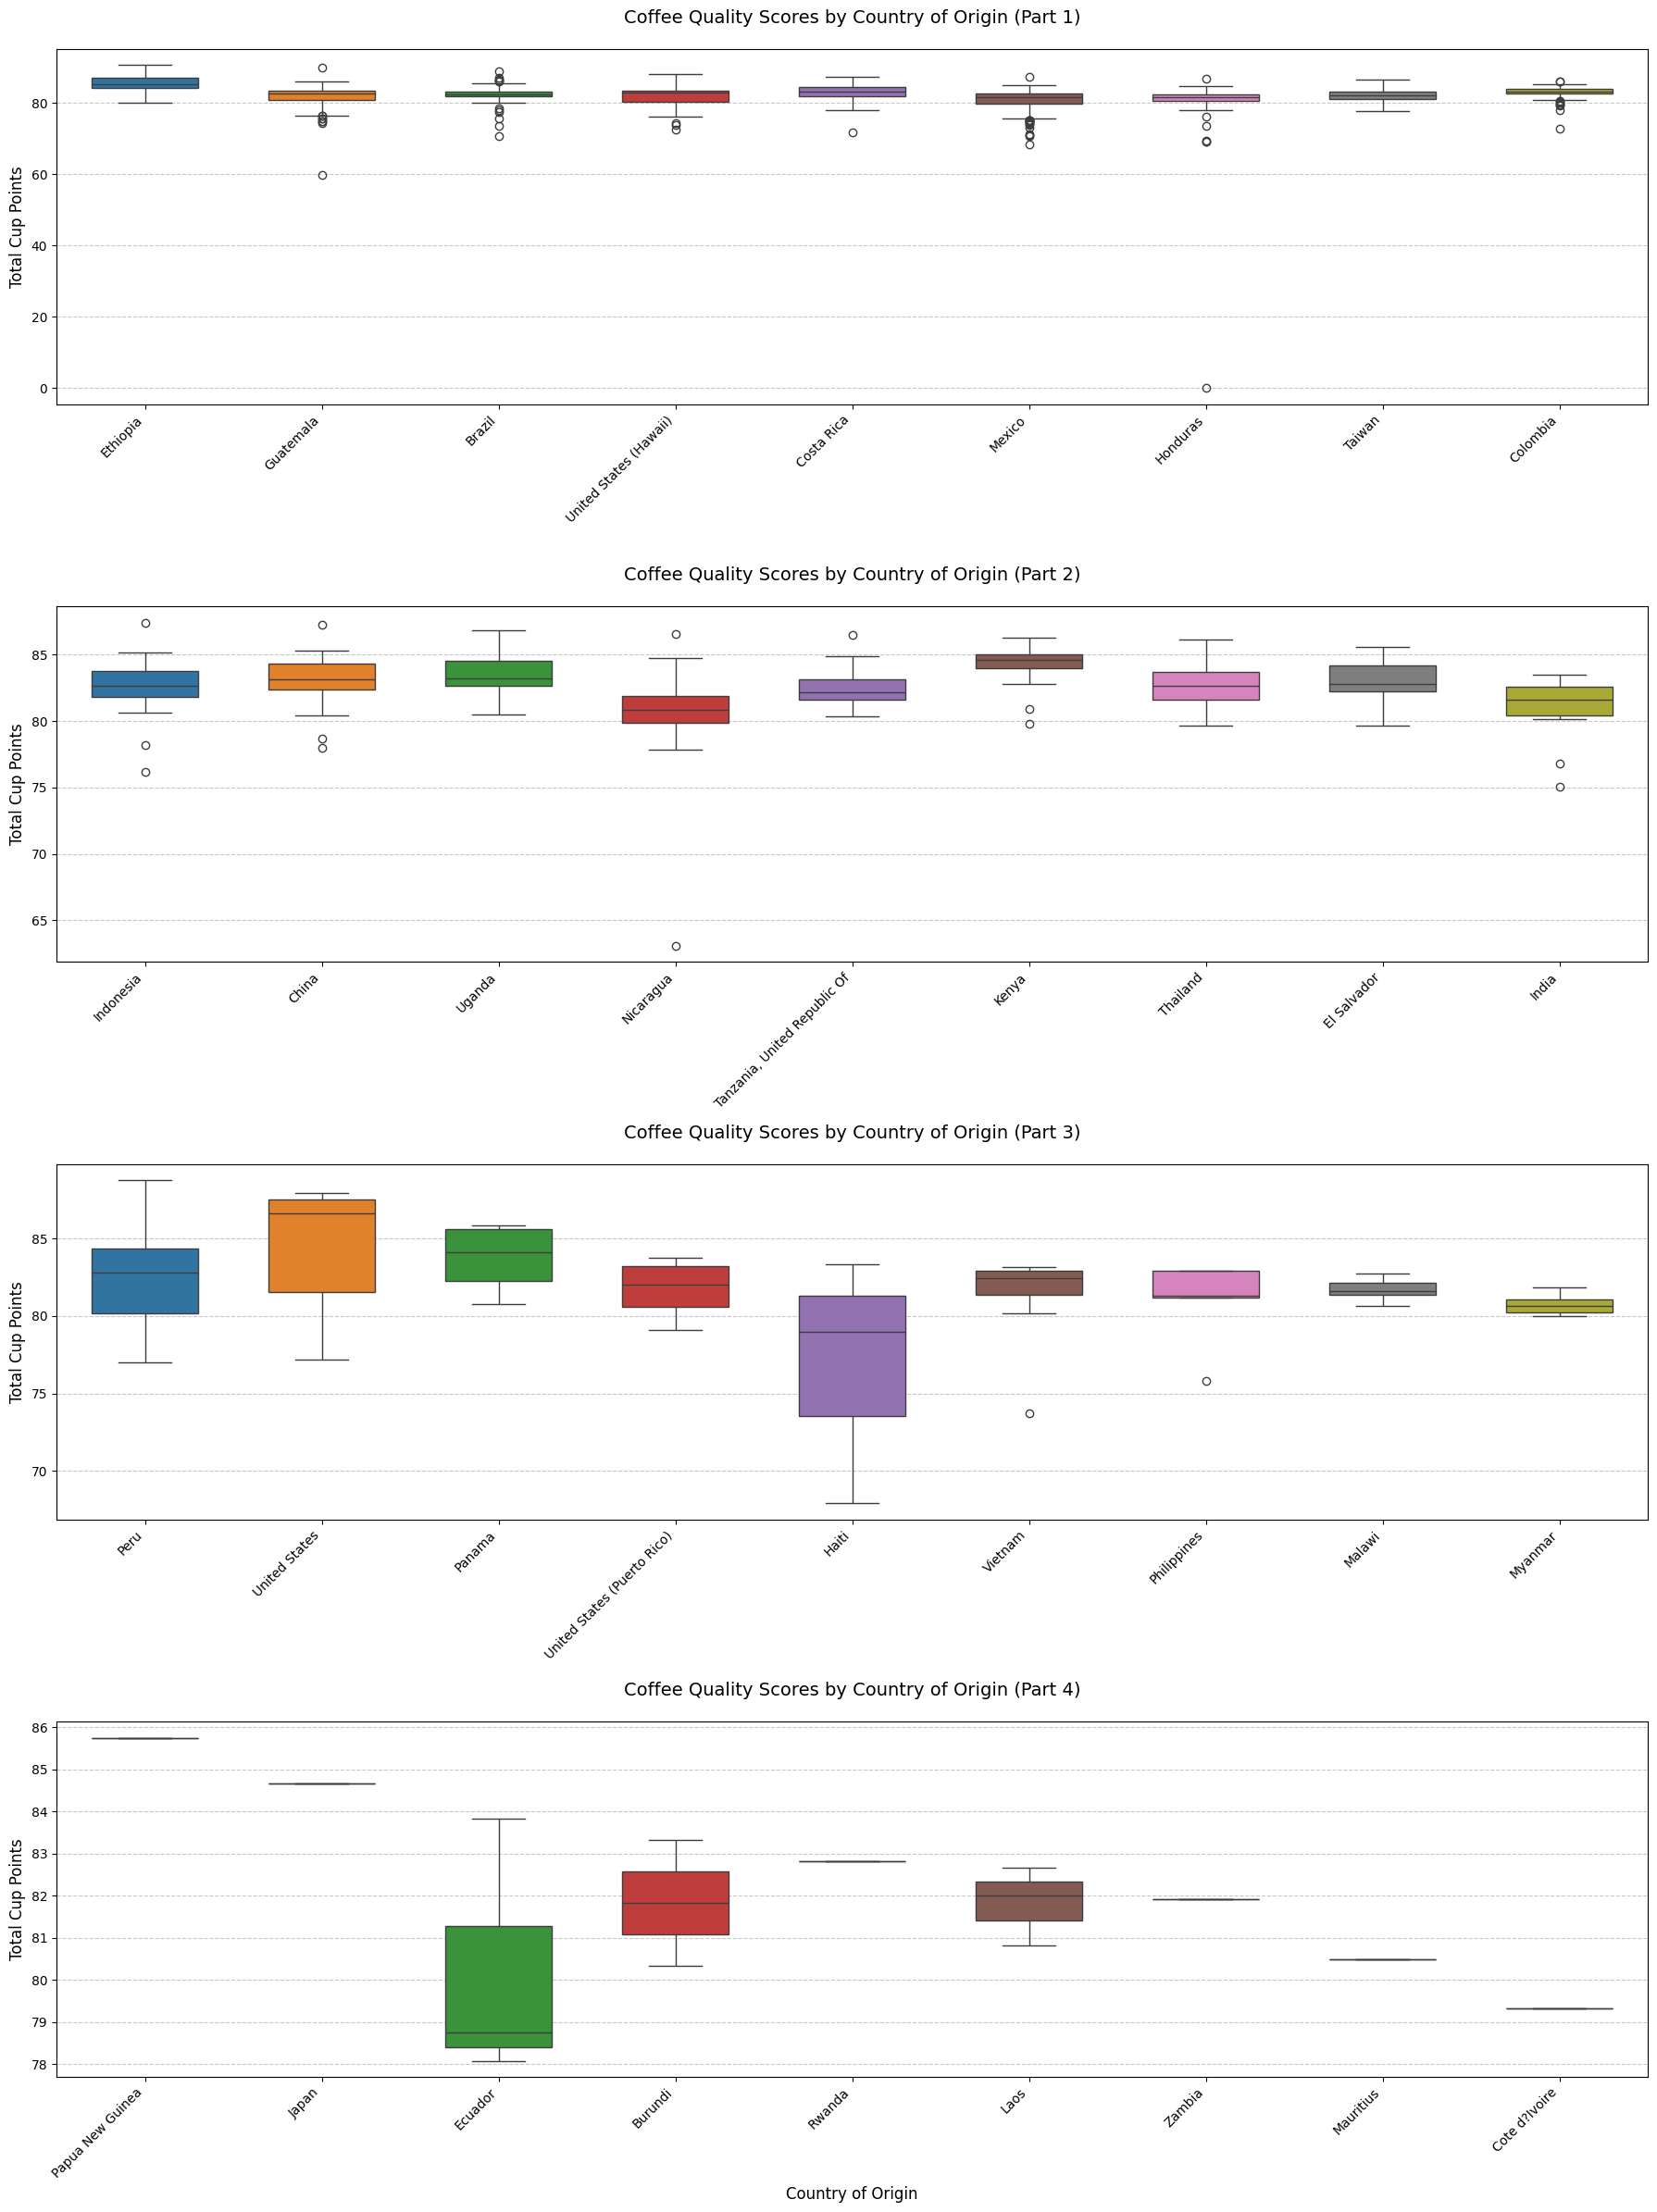


Number of samples per country:
country_of_origin
Mexico                          236
Colombia                        182
Guatemala                       181
Brazil                          132
Taiwan                           75
United States (Hawaii)           73
Honduras                         53
Costa Rica                       51
Ethiopia                         44
Tanzania, United Republic Of     40
Uganda                           36
Thailand                         32
Nicaragua                        26
Kenya                            25
El Salvador                      21
Indonesia                        20
China                            16
India                            14
Malawi                           11
United States                    10
Peru                             10
Myanmar                           8
Vietnam                           8
Haiti                             6
Philippines                       5
United States (Puerto Rico)       4
Panama        

In [14]:
# Get country counts and split into four groups
country_counts = cleaned_df['country_of_origin'].value_counts()
split_point = len(country_counts) // 4
groups = [
   country_counts.index[i*split_point:(i+1)*split_point] 
   for i in range(4)
]

# Create filtered dataframes
dfs = [cleaned_df[cleaned_df['country_of_origin'].isin(group)] for group in groups]

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(18, 24))

# Plot each group
for i, (df, ax) in enumerate(zip(dfs, axes)):
   sns.boxplot(data=df,
               x='country_of_origin',
               y='total_cup_points', 
               hue='country_of_origin',
               width=0.6,
               ax=ax,
               legend=False)
   
   # Customize plot
   ax.set_title(f'Coffee Quality Scores by Country of Origin (Part {i+1})', 
               pad=20, fontsize=14)
   ax.set_xlabel('' if i < 3 else 'Country of Origin', fontsize=12)
   ax.set_ylabel('Total Cup Points', fontsize=12)
   
   # Fix rotation warning by getting current ticks
   ticks = ax.get_xticks()
   ax.set_xticks(ticks)
   ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
   ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("\nNumber of samples per country:")
print(country_counts)

### Correlation matrix of coffee taste profiles

Numeric columns: ['number_of_bags', 'aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance', 'uniformity', 'clean_cup', 'sweetness', 'cupper_points', 'total_cup_points', 'moisture', 'category_one_defects', 'quakers', 'category_two_defects', 'altitude_mean_meters']

Categorical columns: ['species', 'country_of_origin', 'farm_name', 'mill', 'company', 'region', 'producer', 'bag_weight', 'harvest_year', 'variety', 'processing_method', 'color', 'certification_body']


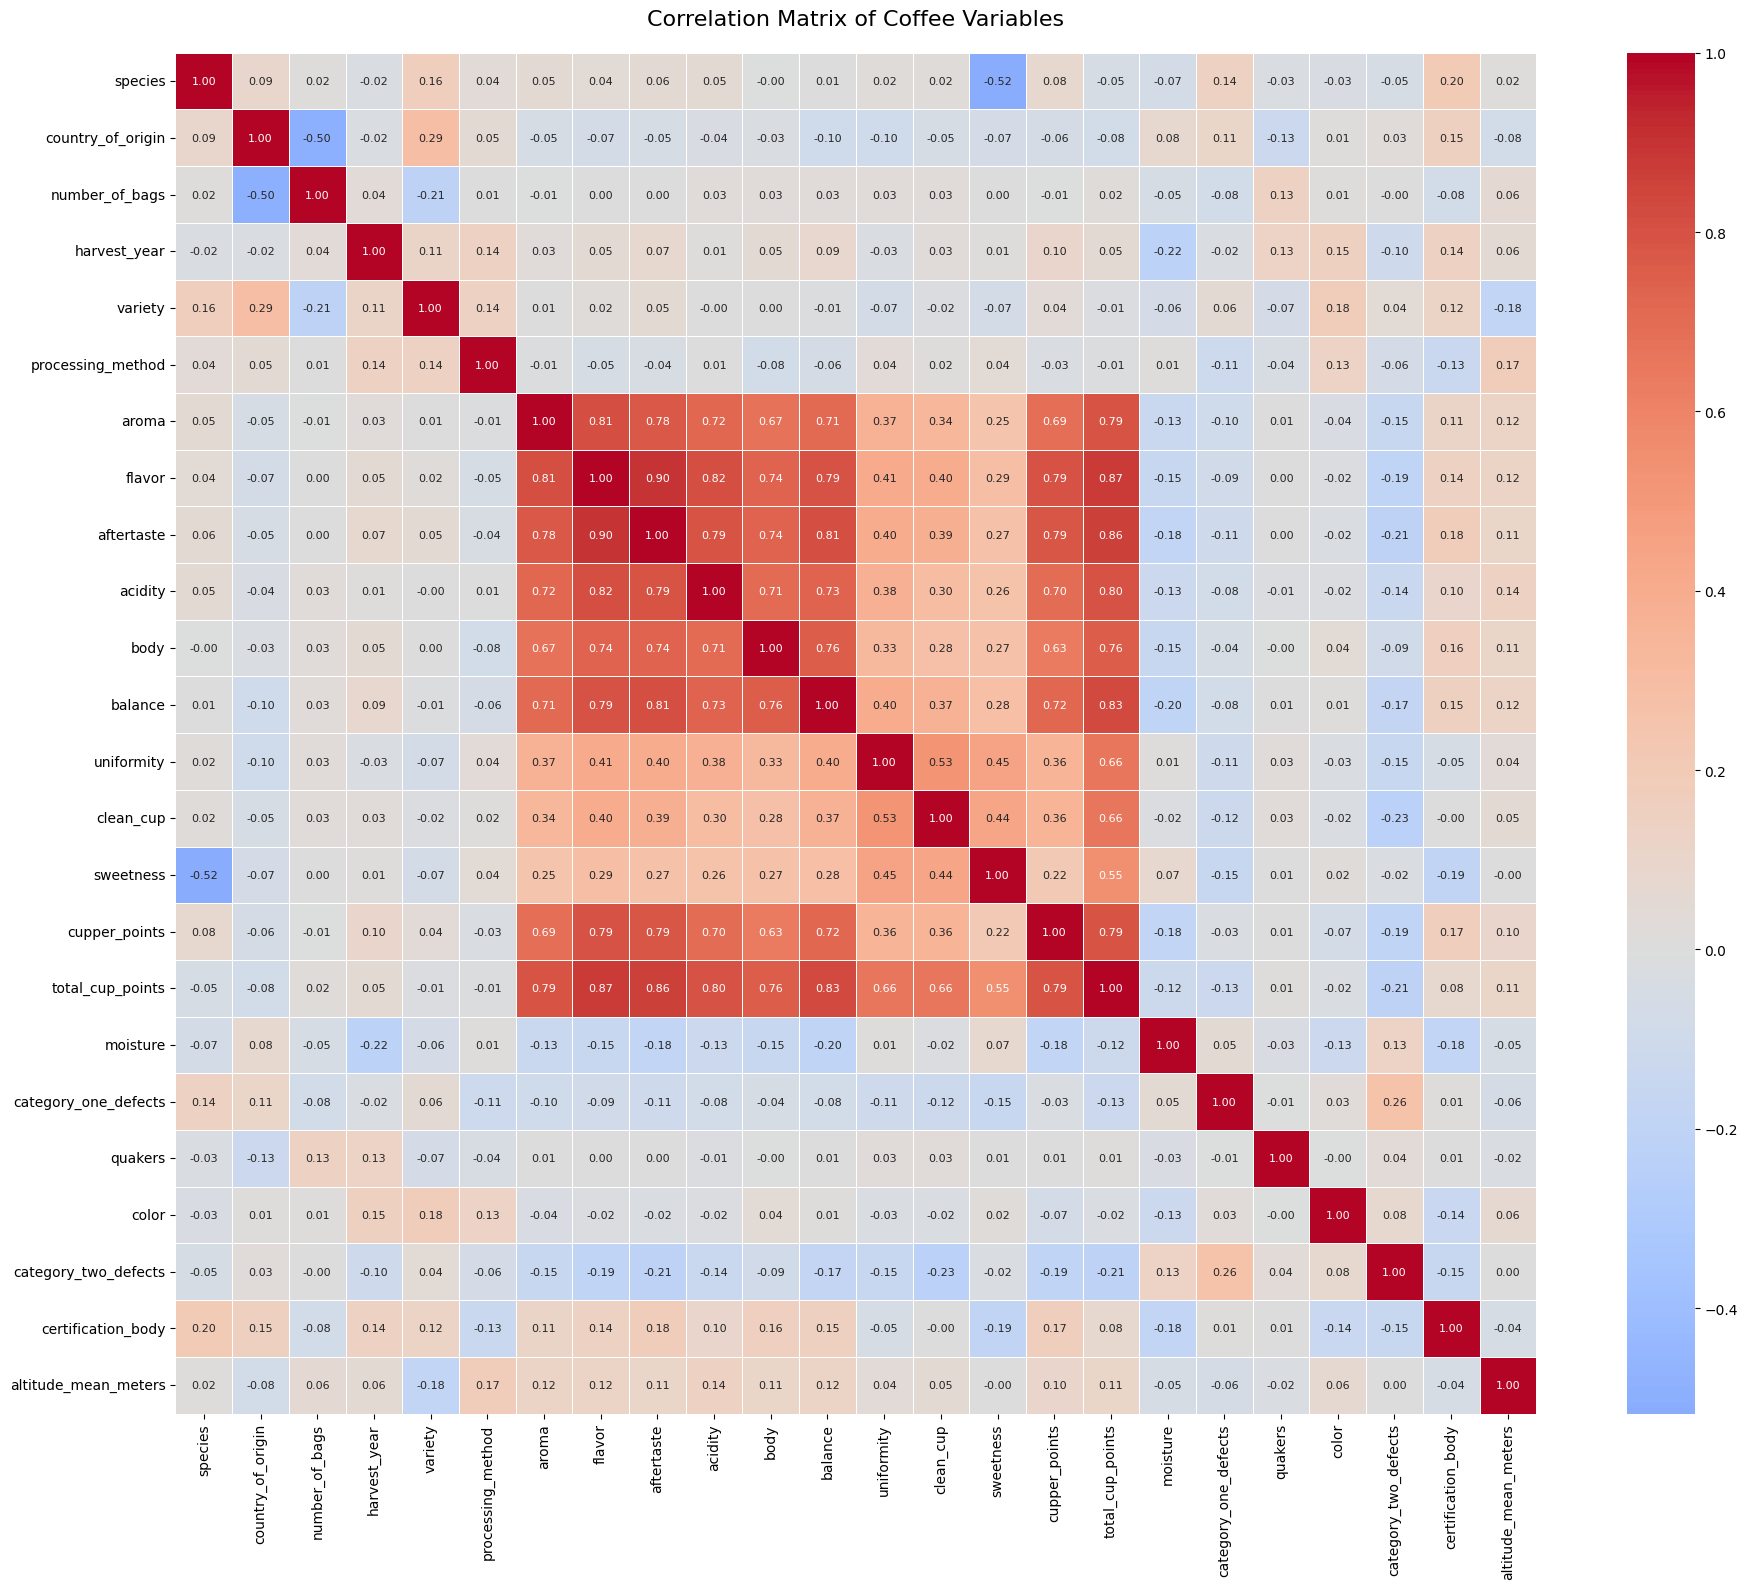


Strongest correlations:
aftertaste        flavor        0.895375
total_cup_points  flavor        0.874487
                  aftertaste    0.861213
                  balance       0.828683
acidity           flavor        0.816178
flavor            aroma         0.812723
balance           aftertaste    0.811316
total_cup_points  acidity       0.797053
cupper_points     flavor        0.793622
balance           flavor        0.793315
dtype: float64


In [15]:
# Create a copy of the dataframe to avoid modifying the original
df_corr = cleaned_df.copy()

# First, identify numeric and categorical columns
numeric_cols = df_corr.select_dtypes(include=[np.number]).columns
categorical_cols = df_corr.select_dtypes(include=['object']).columns

print("Numeric columns:", list(numeric_cols))
print("\nCategorical columns:", list(categorical_cols))

# Encode categorical variables
label_encoder = LabelEncoder()
for col in categorical_cols:
    # Only encode if the column has less than 50 unique values to avoid too many categories
    if df_corr[col].nunique() < 50:
        df_corr[col] = label_encoder.fit_transform(df_corr[col].astype(str))
    else:
        df_corr = df_corr.drop(columns=[col])

# Calculate correlation matrix
correlation_matrix = df_corr.corr()

# Create a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            square=True,  # Make the plot square-shaped
            fmt='.2f',  # Round correlation values to 2 decimal places
            annot_kws={'size': 8},  # Adjust size of correlation values
            linewidths=0.5)  # Add lines between cells

plt.title('Correlation Matrix of Coffee Variables', pad=20, size=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the strongest correlations
print("\nStrongest correlations:")

# Get the upper triangle of the correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Stack the correlations and sort by absolute value
strong_correlations = upper.unstack()
strong_correlations = strong_correlations[strong_correlations != 0].sort_values(key=abs, ascending=False)
print(strong_correlations.head(10))

### Altitude versus total cup points

Text(0.5, 1.0, 'Altitude vs Total Cup Points')

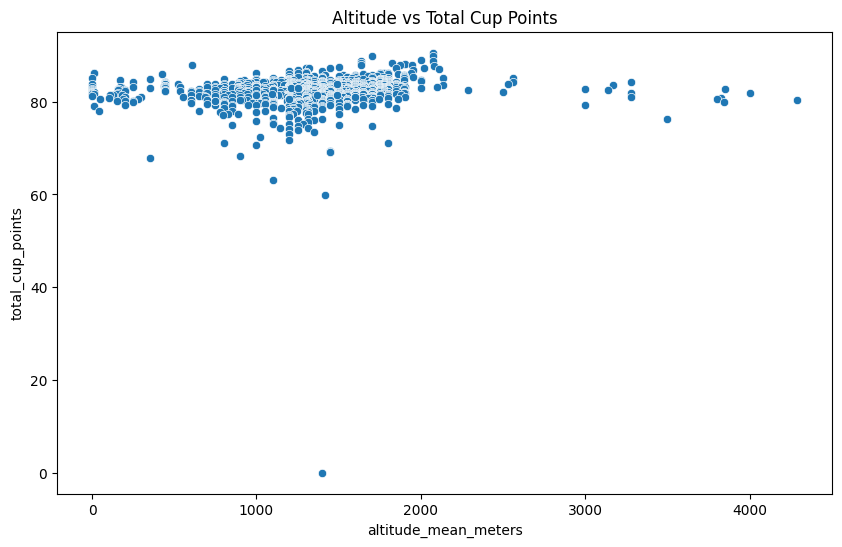

In [16]:
# Analyze relationship between altitude and coffee quality
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_df, x='altitude_mean_meters', y='total_cup_points')
plt.title('Altitude vs Total Cup Points')

### Quality scores by processing method

/var/folders/cq/5p30h6x5741g3nvfdq8t32g40000gn/T/ipykernel_71519/161456582.py:5: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(data=cleaned_df, x='processing_method', y='total_cup_points', hue='processing_method', palette=colors, legend=False)


Text(0.5, 1.0, 'Quality Scores by Processing Method')

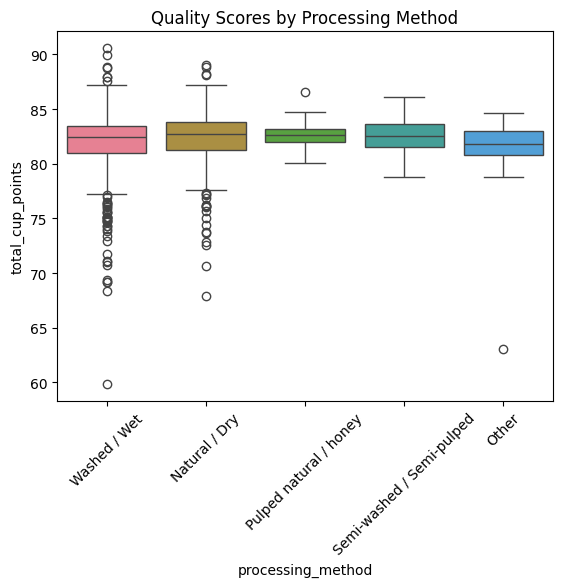

In [17]:
# Get unique processing methods
unique_methods = cleaned_df['processing_method'].unique()
colors = sns.color_palette("husl", len(unique_methods))

sns.boxplot(data=cleaned_df, x='processing_method', y='total_cup_points', hue='processing_method', palette=colors, legend=False)
plt.xticks(rotation=45)
plt.title('Quality Scores by Processing Method')

In [18]:
# Average scores by region
avg_by_region = cleaned_df.groupby('region')['total_cup_points'].mean().sort_values(ascending=False)
print("\nAverage Scores by Region:")
print(avg_by_region)


Average Scores by Region:
region
guji-hambela                       89.776667
snnp/kaffa zone,gimbowereda        88.250000
oromiya                            88.125000
sulawesi                           87.420000
gedio                              87.250000
                                     ...    
marmelade                          72.330000
tlatlauquitepec                    71.080000
sierra norte yajalon, chiapas      70.750000
juchique de ferrer                 68.330000
department d'artibonite , haiti    67.920000
Name: total_cup_points, Length: 356, dtype: float64


### Average total cup points over the years

Original unique values:
['08/09 crop', '1T/2011', '1t/2011', '2009 - 2010', '2009 / 2010', '2009-2010', '2009/2010', '2010', '2010-2011', '2011', '2011/2012', '2012', '2013', '2013/2014', '2014', '2014/2015', '2015', '2015/2016', '2016', '2016 / 2017', '2016/2017', '2017', '2017 / 2018', '2018', '23 July 2010', '3T/2011', '47/2010', '4T/10', '4T/2010', '4T72010', '4t/2010', '4t/2011', 'Abril - Julio', 'Abril - Julio /2011', 'August to December', 'December 2009-March 2010', 'Fall 2009', 'January 2011', 'January Through April', 'March 2010', 'May-August', 'Mayo a Julio', 'Sept 2009 - April 2010', 'Spring 2011 in Colombia.', 'TEST', 'mmm']

Standardized unique values:
[np.float64(2009.0), np.float64(2010.0), np.float64(2011.0), np.float64(2012.0), np.float64(2013.0), np.float64(2014.0), np.float64(2015.0), np.float64(2016.0), np.float64(2017.0), np.float64(2018.0)]


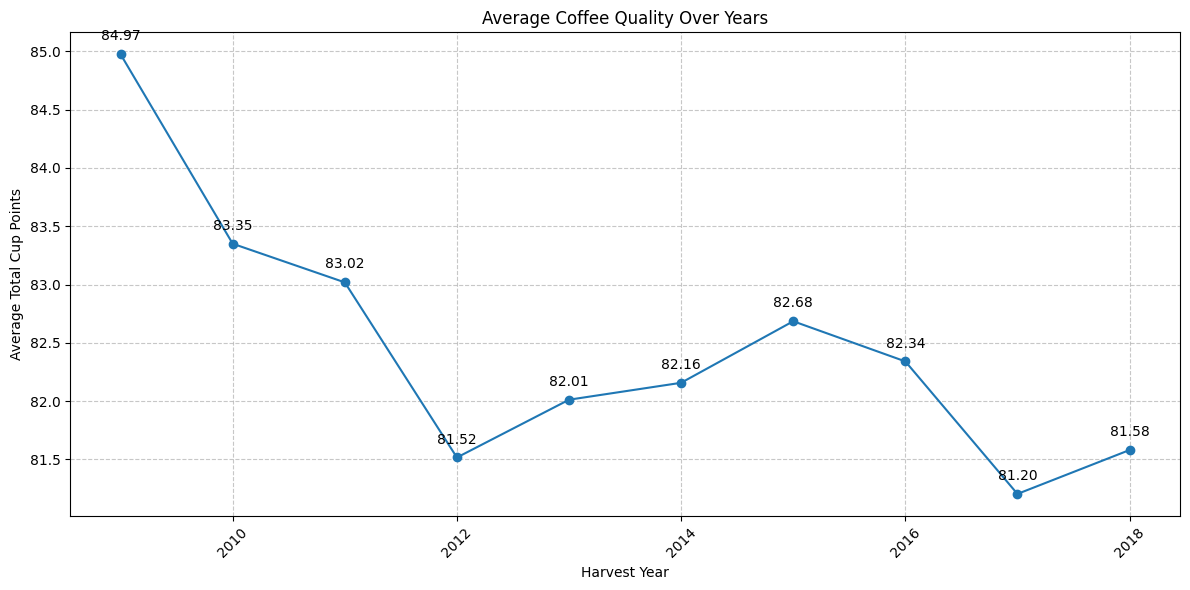


Number of entries per year:
harvest_year_standardized
2009.0     20
2010.0     30
2011.0     36
2012.0    354
2013.0    209
2014.0    252
2015.0    157
2016.0    131
2017.0     89
2018.0      1
Name: count, dtype: int64

Number of NaN values: 58


In [19]:
def standardize_harvest_year(year_str):
    if pd.isna(year_str):
        return np.nan
    
    # Convert to string in case it's already a number
    year_str = str(year_str).strip()
    
    # Simple year pattern (2000-2099)
    year_pattern = r'20[0-9]{2}'
    
    # Cases like '2009/2010' or '2009-2010' or '2009 - 2010'
    split_year_pattern = r'20[0-9]{2}[\s/\-]+20[0-9]{2}'
    
    # If it's a simple year, return it
    if re.match(r'^' + year_pattern + '$', year_str):
        return int(year_str)
    
    # If it's a split year pattern, take the first year
    elif re.match(split_year_pattern, year_str):
        return int(re.findall(year_pattern, year_str)[0])
    
    # Handle specific cases like '4T/10' or '1T/2011'
    elif '/10' in year_str or '/2010' in year_str:
        return 2010
    elif '/11' in year_str or '/2011' in year_str:
        return 2011
    
    # If there's any year in the string, extract the first one
    elif re.search(year_pattern, year_str):
        return int(re.findall(year_pattern, year_str)[0])
    
    # For all other cases, return NaN
    return np.nan

# Create a new column with standardized years
cleaned_df['harvest_year_standardized'] = cleaned_df['harvest_year'].apply(standardize_harvest_year)

# Display unique values before and after standardization
print("Original unique values:")
original_values = cleaned_df['harvest_year'].unique()
# Filter out NaN values for sorting strings
string_values = [str(x) for x in original_values if pd.notna(x)]
print(sorted(string_values))

print("\nStandardized unique values:")
standardized_values = cleaned_df['harvest_year_standardized'].unique()
# Filter out NaN values for sorting numbers
number_values = [x for x in standardized_values if pd.notna(x)]
print(sorted(number_values))

# Now we can create the time series plot with standardized years
yearly_avg = cleaned_df.groupby('harvest_year_standardized')['total_cup_points'].mean()

# Create the plot
plt.figure(figsize=(12, 6))
yearly_avg.plot(kind='line', marker='o')
plt.title('Average Coffee Quality Over Years')
plt.xlabel('Harvest Year')
plt.ylabel('Average Total Cup Points')
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add value labels
for x, y in yearly_avg.items():
    plt.annotate(f'{y:.2f}', 
                (x, y), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nNumber of entries per year:")
print(cleaned_df['harvest_year_standardized'].value_counts().sort_index())
print("\nNumber of NaN values:", cleaned_df['harvest_year_standardized'].isna().sum())

### Analyze impacts of category one defects on quality

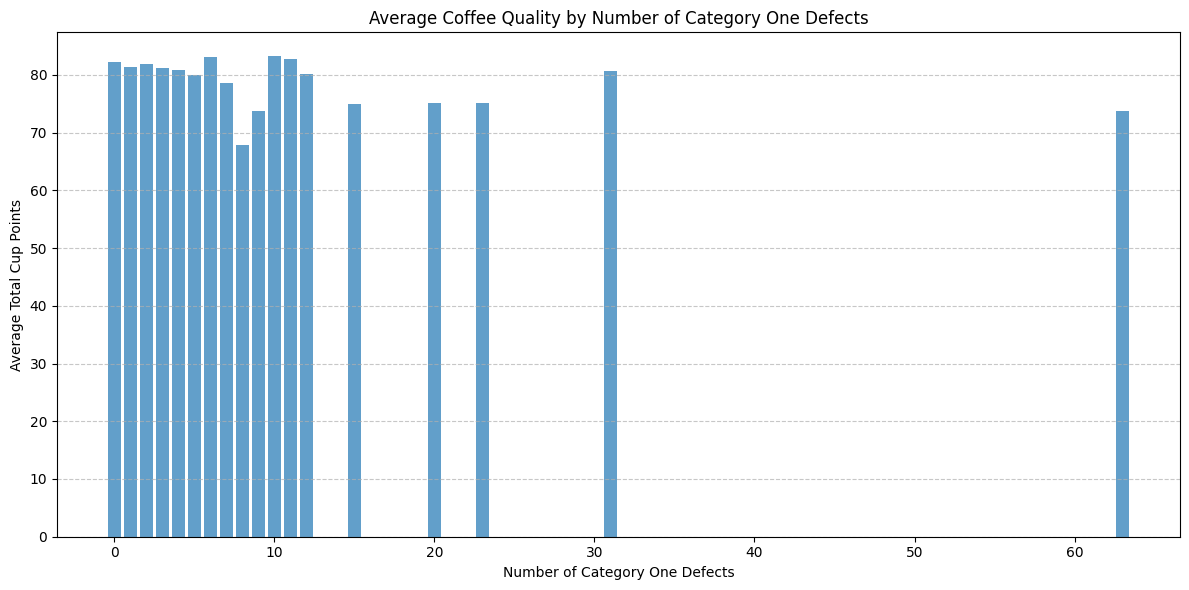

In [20]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Calculate mean total cup points for each category_one_defects value
avg_quality = cleaned_df.groupby('category_one_defects')['total_cup_points'].mean().reset_index()

# Create bar plot
plt.bar(avg_quality['category_one_defects'], avg_quality['total_cup_points'], 
        alpha=0.7)

# Customize the plot
plt.title('Average Coffee Quality by Number of Category One Defects', fontsize=12)
plt.xlabel('Number of Category One Defects', fontsize=10)
plt.ylabel('Average Total Cup Points', fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

### Analyze impacts of category two defects on quality

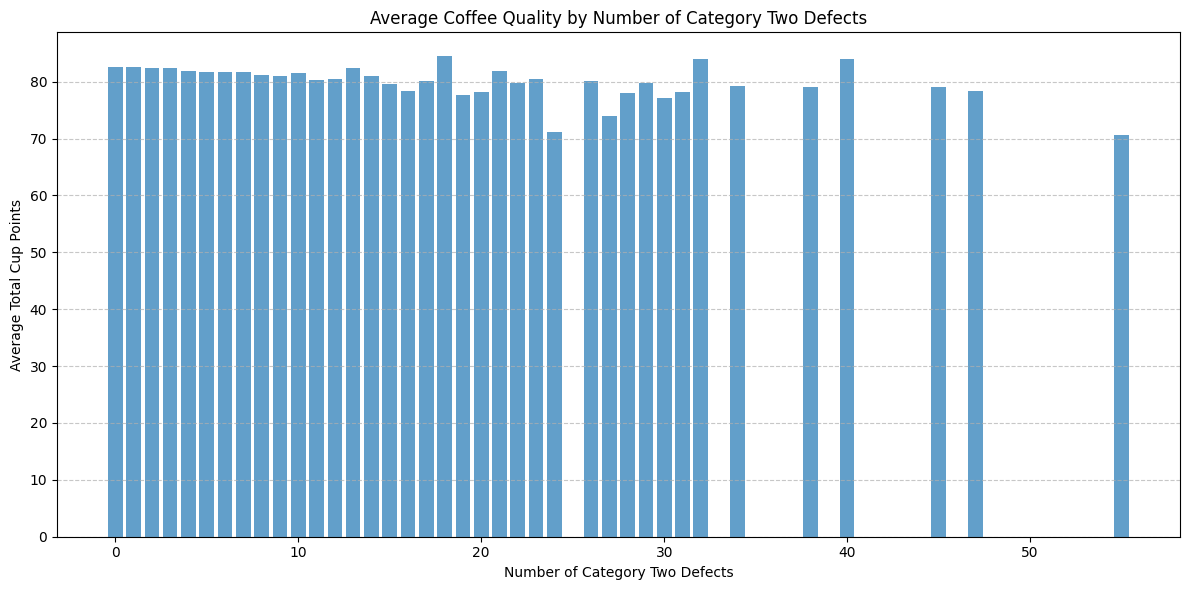

In [21]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Calculate mean total cup points for each category_two_defects value
avg_quality = cleaned_df.groupby('category_two_defects')['total_cup_points'].mean().reset_index()

# Create bar plot
plt.bar(avg_quality['category_two_defects'], avg_quality['total_cup_points'], 
        alpha=0.7)

# Customize the plot
plt.title('Average Coffee Quality by Number of Category Two Defects', fontsize=12)
plt.xlabel('Number of Category Two Defects', fontsize=10)
plt.ylabel('Average Total Cup Points', fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

## Post-process columns to include in the final dataset

In [22]:
label_cols = ['country_of_origin', 'variety', 'processing_method']
feature_cols = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 
                'balance', 'uniformity', 'clean_cup', 'sweetness']

cleaned_df = cleaned_df[feature_cols+label_cols]

### Replace NaN values with the value "Other"
Remove these rows as they are not informative

In [23]:
cleaned_df[['variety', 'processing_method']] = cleaned_df[['variety', 'processing_method']].fillna('Other')
# cleaned_df = cleaned_df[cleaned_df['variety'] != 'Other']
# cleaned_df = cleaned_df[cleaned_df['processing_method'] != 'Other']

### Rename redundantly entitled "United States (Hawaii)" class to just "United States"

In [24]:
# Replace "United States (Hawaii)" with "United States"
cleaned_df['country_of_origin'] = cleaned_df['country_of_origin'].replace('United States (Hawaii)', 'United States')

### Pre-process sparse classes of countries of origin by mapping them to their greater regions

In [25]:
# Mapping for countries below 5% threshold
region_mapping = {
    # Keep major producers (>5%) as is
    
    # Central America
    'Honduras': 'Central America',
    'Costa Rica': 'Central America',
    'El Salvador': 'Central America',
    'Nicaragua': 'Central America',
    'Panama': 'Central America',
    
    # East Africa
    'Kenya': 'East Africa',
    'Uganda': 'East Africa',
    'Tanzania, United Republic Of': 'East Africa',
    'Malawi': 'East Africa',
    'Ethiopia': 'East Africa',
    'Rwanda': 'East Africa',
    'Zambia': 'East Africa',
    'Burundi': 'East Africa',
    
    # Asia Pacific
    'China': 'Asia Pacific',
    'Indonesia': 'Asia Pacific',
    'Thailand': 'Asia Pacific',
    'Myanmar': 'Asia Pacific',
    'Laos': 'Asia Pacific',
    'Vietnam': 'Asia Pacific',
    'Philippines': 'Asia Pacific',
    'Japan': 'Asia Pacific',
    
    # Caribbean
    'Haiti': 'Haiti',
    
    # South America
    'Peru': 'Peru'
}

# Function to apply the mapping while preserving major producers
def map_country(country):
    major_producers = {'Mexico', 'Guatemala', 'Colombia', 'Brazil', 'Taiwan', 'United States'}
    return country if country in major_producers else region_mapping.get(country, 'Other')

# Apply the mapping to create a new column
cleaned_df['country_of_origin'] = cleaned_df['country_of_origin'].apply(map_country)

### Get class distributions

In [26]:
def plot_class_distributions_in_chunks(df, column, chunk_size=12):
    unique_values = df[column].value_counts(dropna=False)
    total_chunks = (len(unique_values) + chunk_size - 1) // chunk_size
    
    # Generate unique colors for each bar
    colors = sns.color_palette("husl", len(unique_values))
    
    for i in range(total_chunks):
        plt.figure(figsize=(12, 6))
        chunk = unique_values[i * chunk_size : (i + 1) * chunk_size]
        chunk_colors = colors[i * chunk_size : (i + 1) * chunk_size]
        chunk.plot(kind='bar', color=chunk_colors)
        plt.title(f"Class Distribution for '{column}' (Chunk {i + 1})", fontsize=16)
        plt.xlabel(column, fontsize=14)
        plt.ylabel("Count", fontsize=14)
        plt.xticks(rotation=45, fontsize=12)
        plt.tight_layout()
        plt.show()

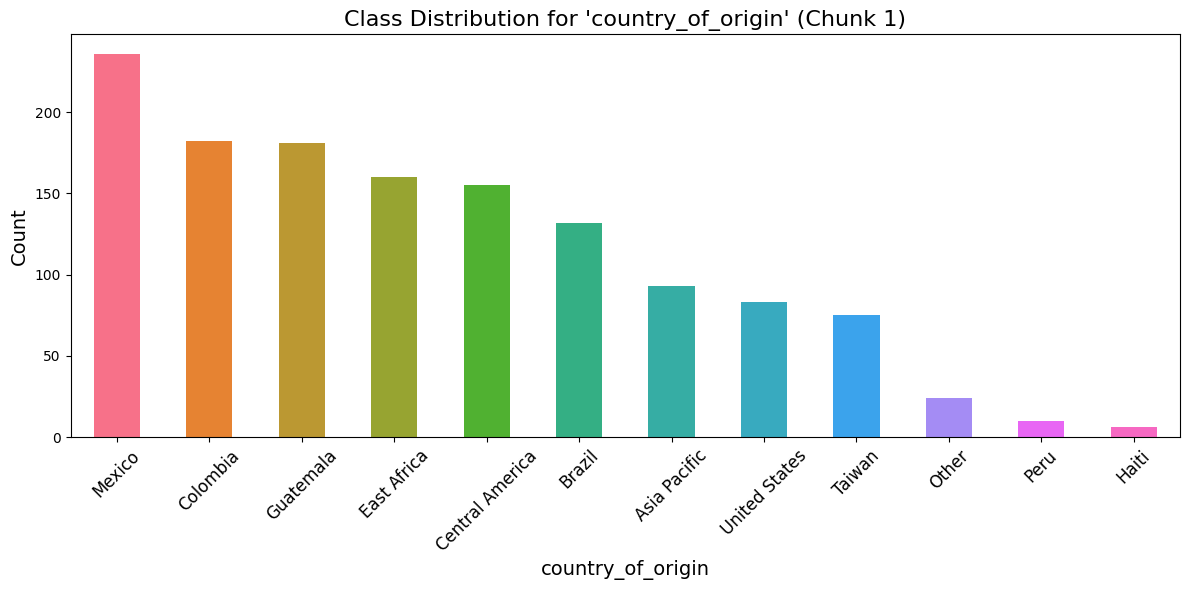

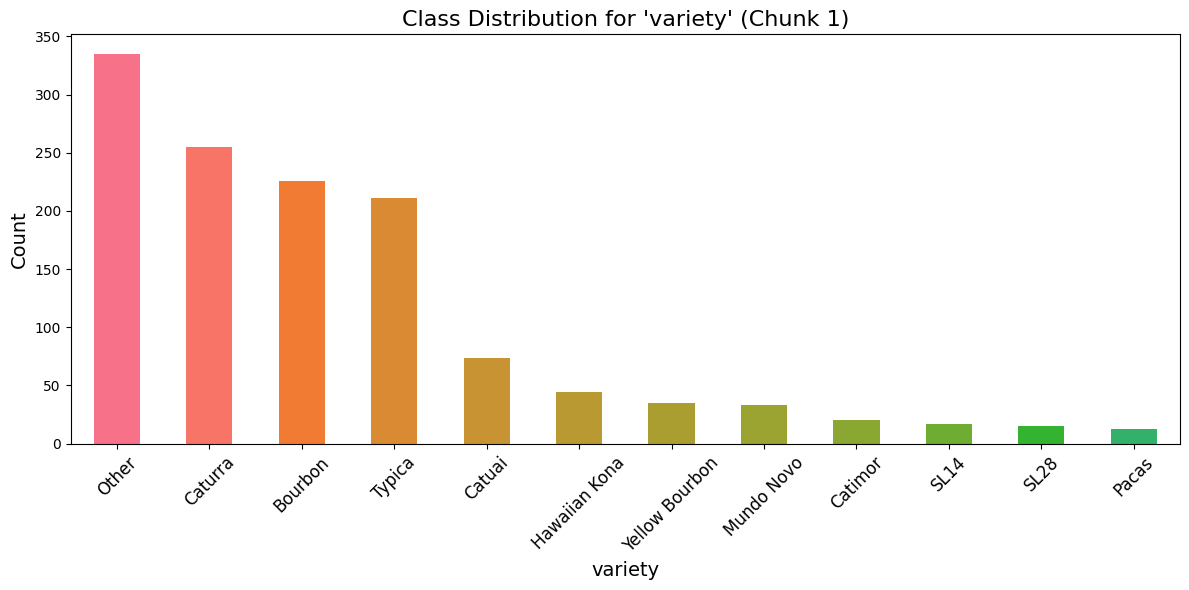

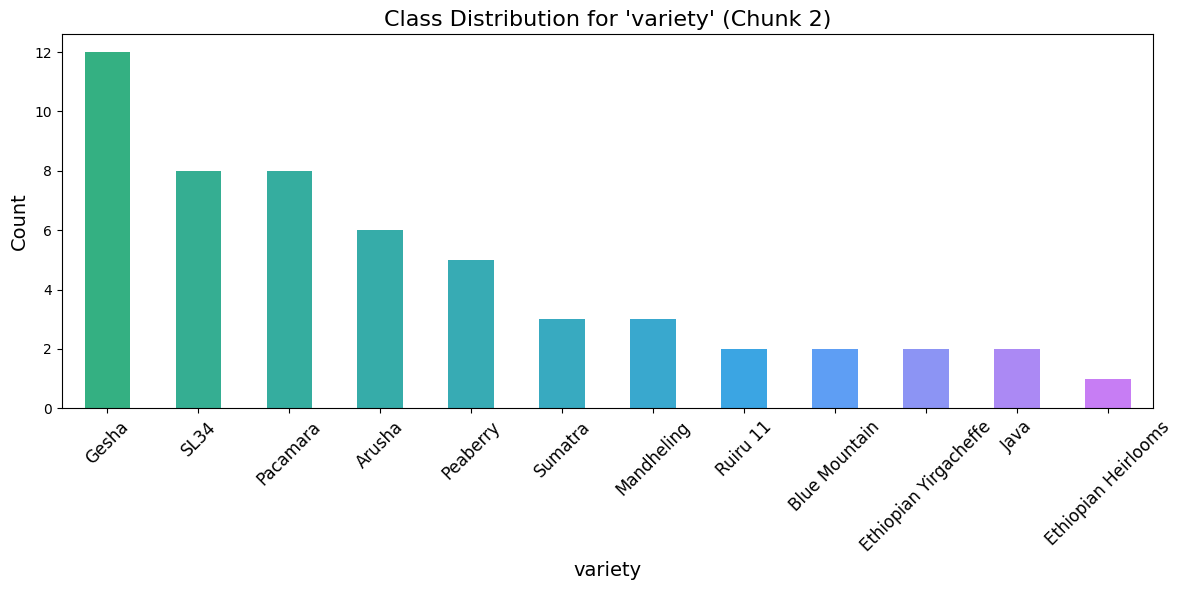

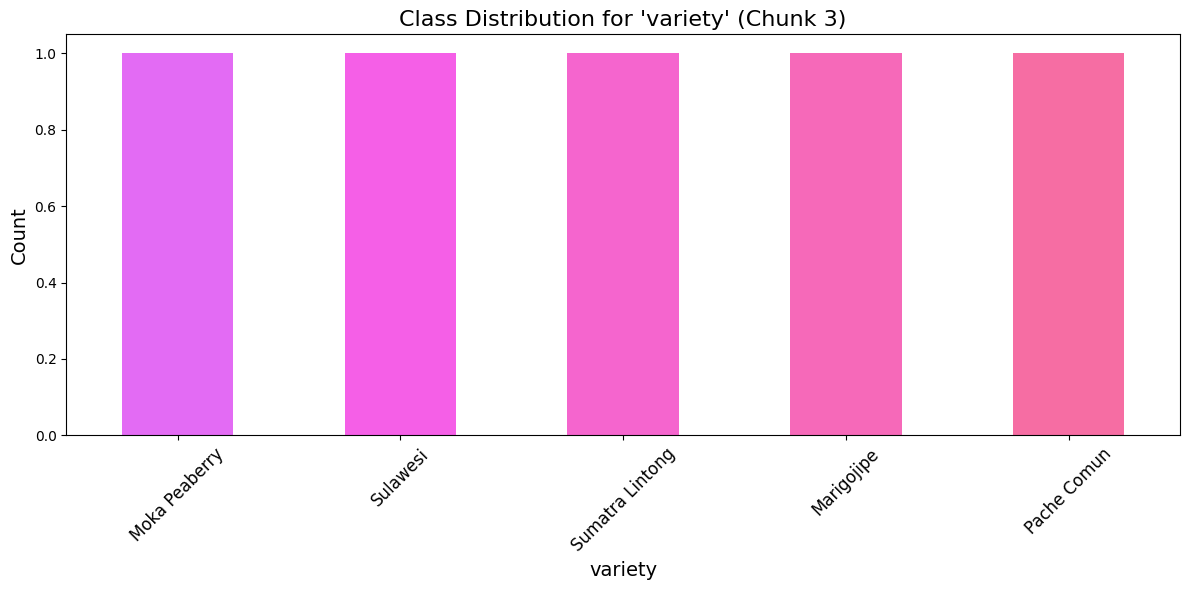

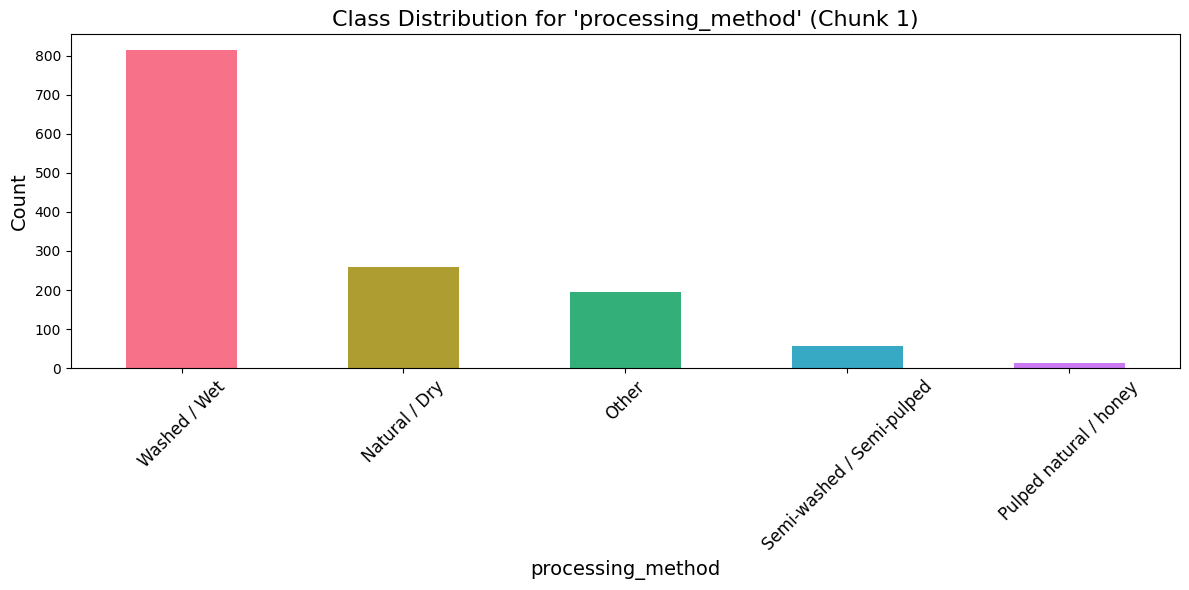

In [27]:
for column in label_cols:
    plot_class_distributions_in_chunks(cleaned_df, column, chunk_size=12)

## Create an augmented dataset using Multi-Label SMOTE

In [28]:
def calculate_synthetic_samples_needed(y_df):
    """
    Calculate the number of synthetic samples needed based on categorical label distribution.
    
    This function:
    1. Analyzes each categorical column separately
    2. Finds the most frequent category in each column
    3. Calculates how many samples are needed to balance the categories
    
    Parameters:
    -----------
    y_df : pandas DataFrame
        DataFrame containing categorical target columns
        
    Returns:
    --------
    int : Number of synthetic samples to generate
    """
    samples_needed = []
    
    for column in y_df.columns:
        # Get value counts for each category in this column
        value_counts = y_df[column].value_counts()
        
        # Find the count of the most frequent category
        max_count = value_counts.max()
        
        # Calculate how many samples needed for each category to match the most frequent
        category_differences = max_count - value_counts
        
        # Sum up the total number of samples needed for this column
        samples_needed.append(category_differences.sum())
    
    # Take the maximum number of samples needed across all columns
    n_samples = max(samples_needed)
    
    return n_samples

def perform_mlsmote(combined_df, target_columns, n_neighbors=5):
    """
    Perform MLSMOTE on a combined dataframe containing both features and categorical target columns.
    
    Parameters:
    -----------
    combined_df : pandas DataFrame
        The input dataframe containing both feature columns and target columns
    target_columns : list
        List of column names that are the categorical target variables
    n_neighbors : int, optional (default=5)
        Number of nearest neighbors to use
    
    Returns:
    --------
    augmented_df : pandas DataFrame
        Original dataframe concatenated with synthetic samples
    n_synthetic : int
        Number of synthetic samples generated
    """
    # Separate features and targets
    X = combined_df.drop(columns=target_columns)
    y = combined_df[target_columns]
    
    # Calculate required number of synthetic samples
    n_samples = calculate_synthetic_samples_needed(y)
    
    # If no synthetic samples are needed, return original data
    if n_samples <= 0:
        return combined_df, 0
    
    # Find minority categories in each target column
    minority_indices = set()
    for column in target_columns:
        value_counts = y[column].value_counts()
        median_count = value_counts.median()
        # Get indices of samples with minority categories
        minority_categories = value_counts[value_counts < median_count].index
        minority_indices.update(y[y[column].isin(minority_categories)].index)
    
    minority_indices = list(minority_indices)
    
    # If not enough minority samples found, return original data
    if len(minority_indices) < n_neighbors:
        return combined_df, 0
    
    X_minority = X.loc[minority_indices].reset_index(drop=True)
    y_minority = y.loc[minority_indices].reset_index(drop=True)
    
    # Find nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean', algorithm='kd_tree').fit(X_minority)
    indices = nbrs.kneighbors(X_minority)[1]
    
    # Generate synthetic samples
    synthetic_X = []
    synthetic_y = []
    
    for i in range(n_samples):
        # Select random reference sample
        reference_idx = random.randint(0, len(X_minority) - 1)
        # Select random neighbor
        neighbor_idx = random.choice(indices[reference_idx, 1:])
        
        # Generate synthetic features
        ratio = random.random()
        gap = X_minority.iloc[reference_idx].values - X_minority.iloc[neighbor_idx].values
        synthetic_features = X_minority.iloc[reference_idx].values + ratio * gap
        
        # For categorical targets, randomly select from k-nearest neighbors
        synthetic_labels = {}
        for column in target_columns:
            neighbor_labels = y_minority.iloc[indices[reference_idx]][column].values
            synthetic_labels[column] = random.choice(neighbor_labels)
        
        synthetic_X.append(synthetic_features)
        synthetic_y.append(synthetic_labels)
    
    # Convert synthetic samples to dataframes
    synthetic_X_df = pd.DataFrame(synthetic_X, columns=X.columns)
    synthetic_y_df = pd.DataFrame(synthetic_y)
    
    # Combine synthetic features and labels
    synthetic_combined = pd.concat([synthetic_X_df, synthetic_y_df], axis=1)
    
    # Combine with original data
    augmented_df = pd.concat([combined_df, synthetic_combined], axis=0).reset_index(drop=True)
    
    return augmented_df, n_samples

def analyze_and_apply_mlsmote(cleaned_df, feature_cols, label_cols):
    """
    Apply MLSMOTE and analyze the results while preserving the original data structure.
    
    This function combines data preparation, MLSMOTE application, and result analysis
    into a single workflow. It provides detailed information about the distribution
    of classes before and after augmentation.
    
    Parameters:
    -----------
    cleaned_df : pandas.DataFrame
        Input DataFrame with all features and labels
    feature_cols : list
        List of feature column names
    label_cols : list
        List of label column names
        
    Returns:
    --------
    tuple: (original_df, augmented_df)
        - Original DataFrame with selected columns
        - Augmented DataFrame after MLSMOTE
    """
    # Input validation
    if not all(col in cleaned_df.columns for col in feature_cols + label_cols):
        raise ValueError("Some specified columns are not in the DataFrame")
    
    # Create DataFrame with only the needed columns
    working_df = cleaned_df[feature_cols + label_cols].copy()
    
    # Print original distribution for all label columns
    print("\nOriginal class distribution:")
    for col in label_cols:
        print(f"\n{col}:")
        value_counts = working_df[col].value_counts()
        print(value_counts)
        print(f"Number of unique {col}: {len(value_counts)}")
    
    try:
        # Apply MLSMOTE
        augmented_df, n_synthetic = perform_mlsmote(
            combined_df=working_df,
            target_columns=label_cols
        )
        
        # Print distribution after MLSMOTE
        print(f"\nGenerated {n_synthetic} synthetic samples")
        print("\nClass distribution after MLSMOTE:")
        for col in label_cols:
            print(f"\n{col}:")
            value_counts = augmented_df[col].value_counts()
            print(value_counts)
            print(f"Number of unique {col}: {len(value_counts)}")
        
        # Print dataset size comparison
        print(f"\nOriginal dataset size: {len(working_df)}")
        print(f"Augmented dataset size: {len(augmented_df)}")
        
        return working_df, augmented_df
        
    except Exception as e:
        print(f"\nError during MLSMOTE: {str(e)}")
        traceback.print_exc()
        print("Returning original dataset only")
        return working_df, working_df

In [29]:
# Apply MLSMOTE and analyze results
original_df, augmented_df = analyze_and_apply_mlsmote(
    cleaned_df=cleaned_df,
    feature_cols=feature_cols,
    label_cols=label_cols
)


Original class distribution:

country_of_origin:
country_of_origin
Mexico             236
Colombia           182
Guatemala          181
East Africa        160
Central America    155
Brazil             132
Asia Pacific        93
United States       83
Taiwan              75
Other               24
Peru                10
Haiti                6
Name: count, dtype: int64
Number of unique country_of_origin: 12

variety:
variety
Other                    335
Caturra                  255
Bourbon                  226
Typica                   211
Catuai                    74
Hawaiian Kona             44
Yellow Bourbon            35
Mundo Novo                33
Catimor                   20
SL14                      17
SL28                      15
Pacas                     13
Gesha                     12
SL34                       8
Pacamara                   8
Arusha                     6
Peaberry                   5
Sumatra                    3
Mandheling                 3
Ruiru 11              

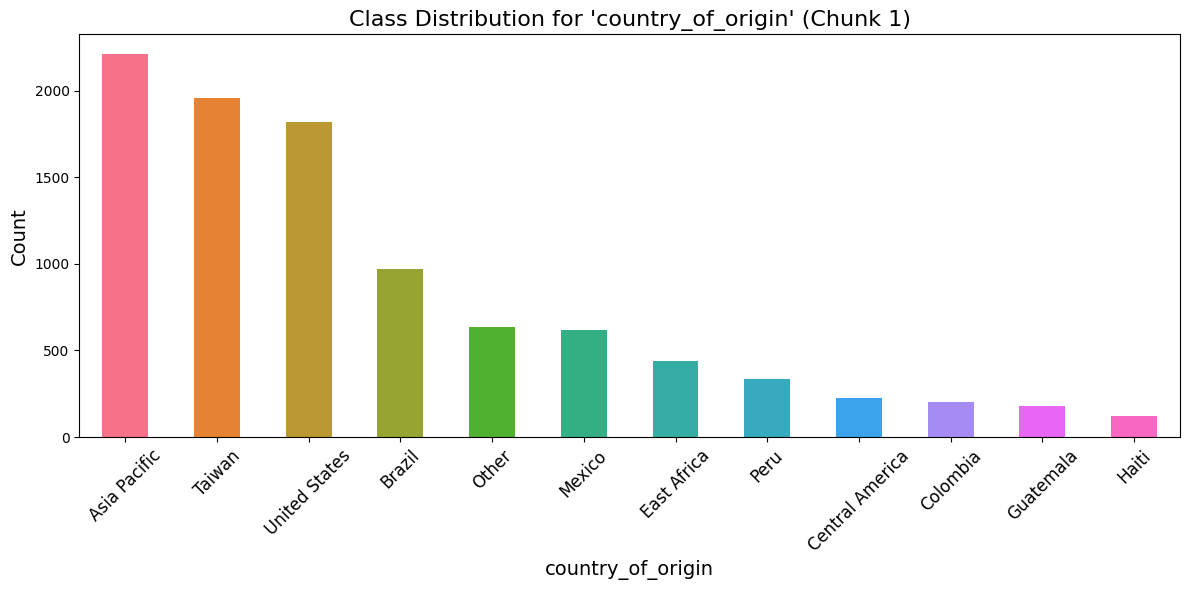

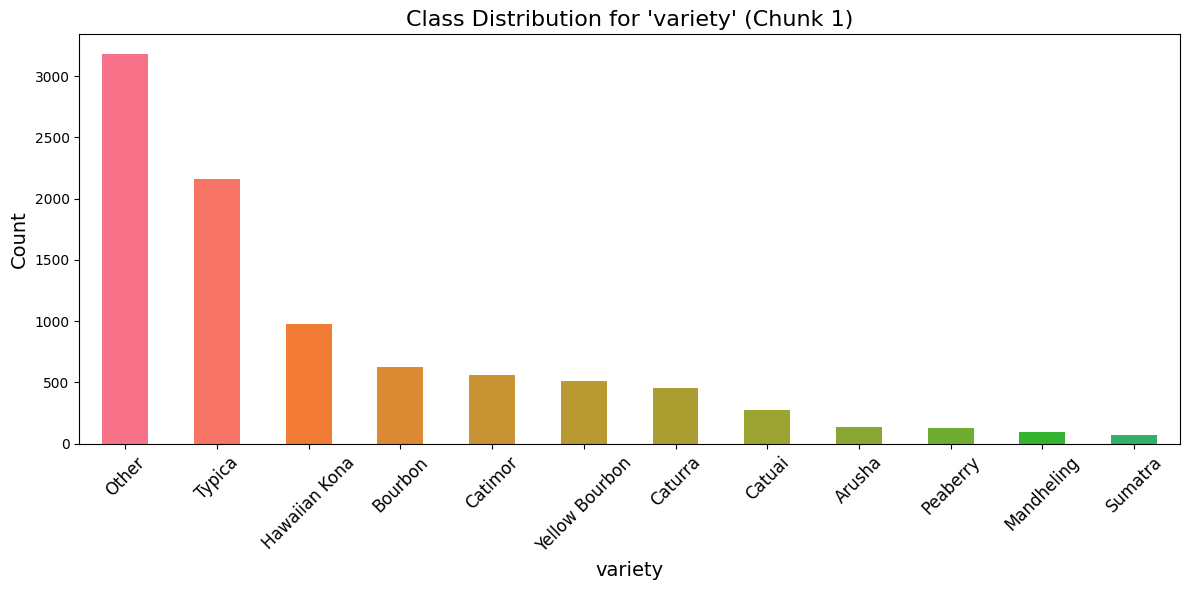

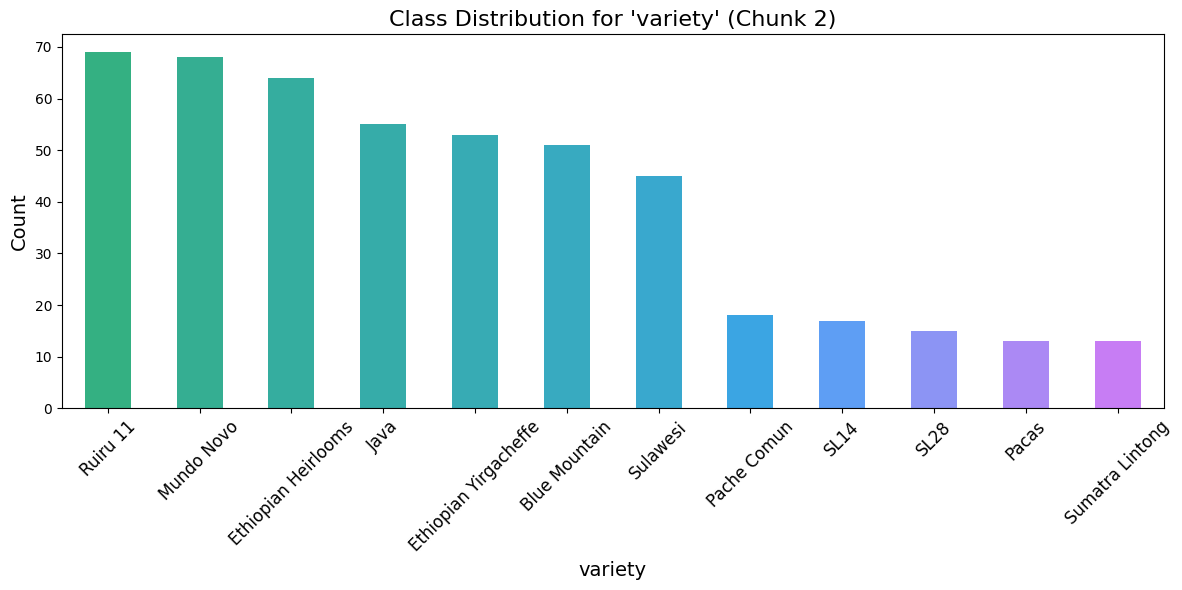

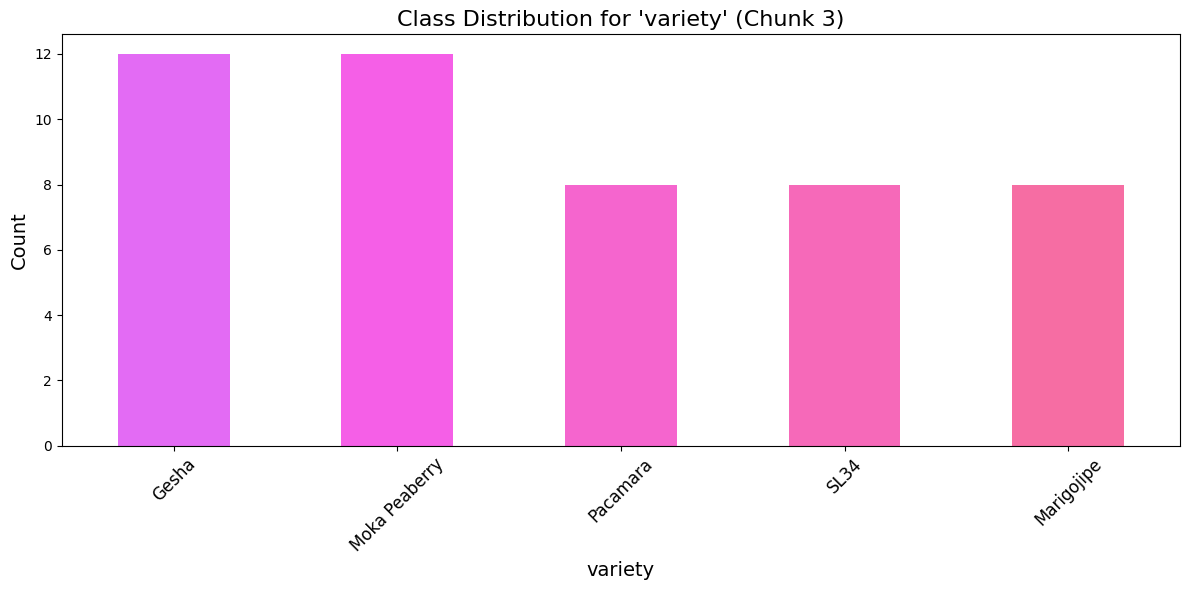

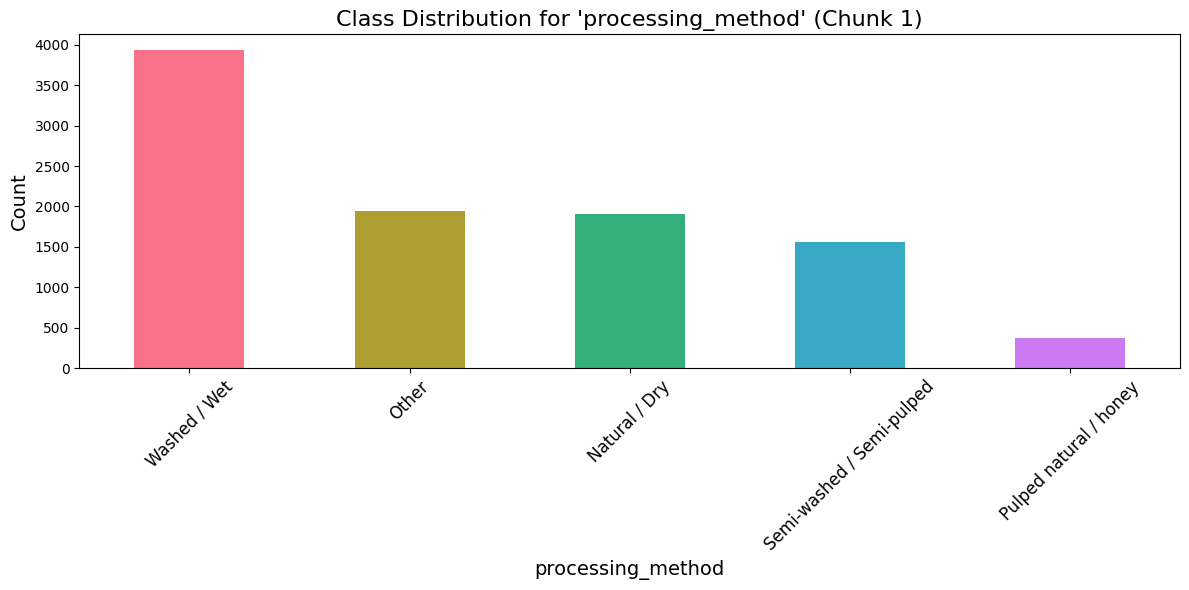

In [30]:
for column in label_cols:
    plot_class_distributions_in_chunks(augmented_df, column, chunk_size=12)

## Save the original and augmented datasets as CSV files
Write the cleaned dataframe into a CSV file dataset with the format $[X|y]$

In [31]:
original_dataset_path = 'datasets/preprocessed_coffee_data.csv'
original_df.to_csv(original_dataset_path, index=False, encoding='utf-8')
print(f"Successfully saved original dataset to {original_dataset_path}")

augmented_dataset_path = 'datasets/preprocessed_coffee_data_resampled.csv'
augmented_df.to_csv(augmented_dataset_path, index=False, encoding='utf-8')
print(f"Successfully saved augmented dataset to {augmented_dataset_path}")

Successfully saved original dataset to datasets/preprocessed_coffee_data.csv
Successfully saved augmented dataset to datasets/preprocessed_coffee_data_resampled.csv
